# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Campo 100 puntos'

## Datos de entrenamiento

### Datos

In [5]:
campvectrain = np.load(path + '/campvectrain.npy')

In [6]:
np.shape(campvectrain)

(7000, 2, 100, 100)

### Coeficientes

In [7]:
coefcampvectrain = np.load(path + '/coefcampvectrain.npy')

In [8]:
np.shape(coefcampvectrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
campvectest = np.load(path + '/campvectest.npy')

In [10]:
np.shape(campvectest)

(2000, 2, 100, 100)

### Coeficientes

In [11]:
coefcampvectest = np.load(path + '/coefcampvectest.npy')

In [12]:
np.shape(coefcampvectest)

(2000, 7)

## Datos de validación

### Datos

In [13]:
campvecval = np.load(path + '/campvecval.npy')

In [14]:
np.shape(campvecval)

(1000, 2, 100, 100)

### Coeficienes

In [15]:
coefcampvecval = np.load(path + '/coefcampvecval.npy')

In [16]:
np.shape(coefcampvecval)

(1000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((campvectrain, coefcampvectrain))
test_dataset = tf.data.Dataset.from_tensor_slices((campvectest, coefcampvectest))
val_dataset = tf.data.Dataset.from_tensor_slices((campvecval, coefcampvecval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(2, 100, 100), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 10

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [63]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(2,100,100)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7)
])


In [64]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 20000)             0         
                                                                 
 batch_normalization_10 (Bat  (None, 20000)            80000     
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            (None, 100)               2000100   
                                                                 
 dense_26 (Dense)            (None, 100)               10100     
                                                                 
 dense_27 (Dense)            (None, 50)                5050      
                                                                 
 dense_28 (Dense)            (None, 25)                1275      
                                                      

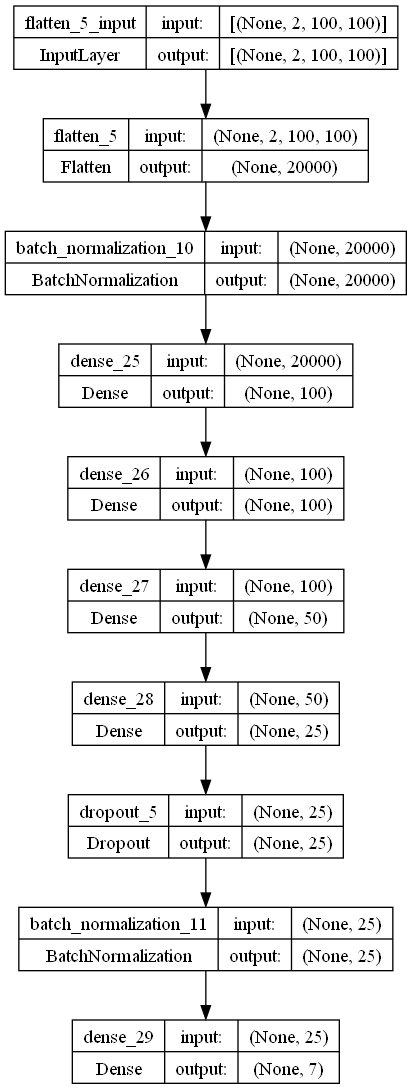

In [65]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [66]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [67]:
model.compile(optimizer=optimizer,
              loss= 'mae',
              metrics=['mae'])

In [68]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [ ]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
700/700 [==============================] - 5s 7ms/step - loss: 2.9054 - mae: 2.9054 - val_loss: 1.6440 - val_mae: 1.6440 - lr: 0.0010
Epoch 2/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.9805 - mae: 1.9805 - val_loss: 1.5853 - val_mae: 1.5853 - lr: 0.0010
Epoch 3/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.8863 - mae: 1.8863 - val_loss: 1.4418 - val_mae: 1.4418 - lr: 0.0010
Epoch 4/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.8054 - mae: 1.8054 - val_loss: 1.3398 - val_mae: 1.3398 - lr: 0.0010
Epoch 5/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.6837 - mae: 1.6837 - val_loss: 1.1896 - val_mae: 1.1896 - lr: 0.0010
Epoch 6/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.6387 - mae: 1.6387 - val_loss: 1.1101 - val_mae: 1.1101 - lr: 0.0010
Epoch 7/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.6301 - mae: 1.6301 - val_loss: 1.1195 - 

700/700 [==============================] - 5s 7ms/step - loss: 1.4683 - mae: 1.4683 - val_loss: 0.8691 - val_mae: 0.8691 - lr: 0.0010
Epoch 112/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4714 - mae: 1.4714 - val_loss: 0.8469 - val_mae: 0.8469 - lr: 0.0010
Epoch 113/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4642 - mae: 1.4642 - val_loss: 0.8539 - val_mae: 0.8539 - lr: 0.0010
Epoch 114/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4525 - mae: 1.4525 - val_loss: 0.8687 - val_mae: 0.8687 - lr: 0.0010
Epoch 115/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4523 - mae: 1.4523 - val_loss: 0.8406 - val_mae: 0.8406 - lr: 0.0010
Epoch 116/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4655 - mae: 1.4655 - val_loss: 0.8707 - val_mae: 0.8707 - lr: 0.0010
Epoch 117/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.4623 - mae: 1.4623 - val_loss: 0.8422 - v

700/700 [==============================] - 5s 7ms/step - loss: 1.4584 - mae: 1.4584 - val_loss: 0.8436 - val_mae: 0.8436 - lr: 0.0010
Epoch 167/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4526 - mae: 1.4526 - val_loss: 0.8193 - val_mae: 0.8193 - lr: 0.0010
Epoch 168/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4596 - mae: 1.4596 - val_loss: 0.8685 - val_mae: 0.8685 - lr: 0.0010
Epoch 169/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4537 - mae: 1.4537 - val_loss: 0.8528 - val_mae: 0.8528 - lr: 0.0010
Epoch 170/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4528 - mae: 1.4528 - val_loss: 0.8327 - val_mae: 0.8327 - lr: 0.0010
Epoch 171/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4474 - mae: 1.4474 - val_loss: 0.8708 - val_mae: 0.8708 - lr: 0.0010
Epoch 172/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4596 - mae: 1.4596 - val_loss: 0.8636 - v

700/700 [==============================] - 5s 7ms/step - loss: 1.4500 - mae: 1.4500 - val_loss: 0.8036 - val_mae: 0.8036 - lr: 0.0010
Epoch 222/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4505 - mae: 1.4505 - val_loss: 0.8093 - val_mae: 0.8093 - lr: 0.0010
Epoch 223/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4575 - mae: 1.4575 - val_loss: 0.8104 - val_mae: 0.8104 - lr: 0.0010
Epoch 224/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4525 - mae: 1.4525 - val_loss: 0.8215 - val_mae: 0.8215 - lr: 0.0010
Epoch 225/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4542 - mae: 1.4542 - val_loss: 0.8463 - val_mae: 0.8463 - lr: 0.0010
Epoch 226/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4437 - mae: 1.4437 - val_loss: 0.8308 - val_mae: 0.8308 - lr: 0.0010
Epoch 227/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4440 - mae: 1.4440 - val_loss: 0.7996 - v

700/700 [==============================] - 5s 7ms/step - loss: 1.4489 - mae: 1.4489 - val_loss: 0.8352 - val_mae: 0.8352 - lr: 0.0010
Epoch 277/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4608 - mae: 1.4608 - val_loss: 0.8197 - val_mae: 0.8197 - lr: 0.0010
Epoch 278/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4366 - mae: 1.4366 - val_loss: 0.8172 - val_mae: 0.8172 - lr: 0.0010
Epoch 279/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4503 - mae: 1.4503 - val_loss: 0.8042 - val_mae: 0.8042 - lr: 0.0010
Epoch 280/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4415 - mae: 1.4415 - val_loss: 0.8368 - val_mae: 0.8368 - lr: 0.0010
Epoch 281/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4459 - mae: 1.4459 - val_loss: 0.8112 - val_mae: 0.8112 - lr: 0.0010
Epoch 282/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4453 - mae: 1.4453 - val_loss: 0.8426 - v

700/700 [==============================] - 5s 7ms/step - loss: 1.4424 - mae: 1.4424 - val_loss: 0.8465 - val_mae: 0.8465 - lr: 0.0010
Epoch 332/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4422 - mae: 1.4422 - val_loss: 0.8376 - val_mae: 0.8376 - lr: 0.0010
Epoch 333/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4398 - mae: 1.4398 - val_loss: 0.8445 - val_mae: 0.8445 - lr: 0.0010
Epoch 334/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4414 - mae: 1.4414 - val_loss: 0.8364 - val_mae: 0.8364 - lr: 0.0010
Epoch 335/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4444 - mae: 1.4444 - val_loss: 0.8258 - val_mae: 0.8258 - lr: 0.0010
Epoch 336/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4431 - mae: 1.4431 - val_loss: 0.8389 - val_mae: 0.8389 - lr: 0.0010
Epoch 337/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4301 - mae: 1.4301 - val_loss: 0.8553 - v

700/700 [==============================] - 5s 7ms/step - loss: 1.4387 - mae: 1.4387 - val_loss: 0.8174 - val_mae: 0.8174 - lr: 0.0010
Epoch 387/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4409 - mae: 1.4409 - val_loss: 0.8301 - val_mae: 0.8301 - lr: 0.0010
Epoch 388/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4361 - mae: 1.4361 - val_loss: 0.8566 - val_mae: 0.8566 - lr: 0.0010
Epoch 389/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4373 - mae: 1.4373 - val_loss: 0.8347 - val_mae: 0.8347 - lr: 0.0010
Epoch 390/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4433 - mae: 1.4433 - val_loss: 0.8260 - val_mae: 0.8260 - lr: 0.0010
Epoch 391/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4401 - mae: 1.4401 - val_loss: 0.8405 - val_mae: 0.8405 - lr: 0.0010
Epoch 392/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4473 - mae: 1.4473 - val_loss: 0.8378 - v

700/700 [==============================] - 5s 7ms/step - loss: 1.4320 - mae: 1.4320 - val_loss: 0.8446 - val_mae: 0.8446 - lr: 9.3565e-04
Epoch 441/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4411 - mae: 1.4411 - val_loss: 0.8500 - val_mae: 0.8500 - lr: 9.3400e-04
Epoch 442/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4321 - mae: 1.4321 - val_loss: 0.8304 - val_mae: 0.8304 - lr: 9.3235e-04
Epoch 443/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4238 - mae: 1.4238 - val_loss: 0.8402 - val_mae: 0.8402 - lr: 9.3070e-04
Epoch 444/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4410 - mae: 1.4410 - val_loss: 0.8398 - val_mae: 0.8398 - lr: 9.2905e-04
Epoch 445/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4364 - mae: 1.4364 - val_loss: 0.8421 - val_mae: 0.8421 - lr: 9.2740e-04
Epoch 446/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4307 - mae: 1.430

Epoch 494/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4434 - mae: 1.4434 - val_loss: 0.8264 - val_mae: 0.8264 - lr: 8.4655e-04
Epoch 495/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4339 - mae: 1.4339 - val_loss: 0.8120 - val_mae: 0.8120 - lr: 8.4490e-04
Epoch 496/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4358 - mae: 1.4358 - val_loss: 0.8350 - val_mae: 0.8350 - lr: 8.4325e-04
Epoch 497/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4397 - mae: 1.4397 - val_loss: 0.8276 - val_mae: 0.8276 - lr: 8.4160e-04
Epoch 498/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4298 - mae: 1.4298 - val_loss: 0.8412 - val_mae: 0.8412 - lr: 8.3995e-04
Epoch 499/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4342 - mae: 1.4342 - val_loss: 0.8244 - val_mae: 0.8244 - lr: 8.3830e-04
Epoch 500/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.42

Epoch 601/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.4323 - mae: 1.4323 - val_loss: 0.8264 - val_mae: 0.8264 - lr: 6.7000e-04
Epoch 602/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4329 - mae: 1.4329 - val_loss: 0.8202 - val_mae: 0.8202 - lr: 6.6835e-04
Epoch 603/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4370 - mae: 1.4370 - val_loss: 0.8292 - val_mae: 0.8292 - lr: 6.6670e-04
Epoch 604/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4368 - mae: 1.4368 - val_loss: 0.8306 - val_mae: 0.8306 - lr: 6.6505e-04
Epoch 605/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4323 - mae: 1.4323 - val_loss: 0.8291 - val_mae: 0.8291 - lr: 6.6340e-04
Epoch 606/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4210 - mae: 1.4210 - val_loss: 0.8409 - val_mae: 0.8409 - lr: 6.6175e-04
Epoch 607/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.43

Epoch 708/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.4199 - mae: 1.4199 - val_loss: 0.8275 - val_mae: 0.8275 - lr: 4.9345e-04
Epoch 709/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4192 - mae: 1.4192 - val_loss: 0.8181 - val_mae: 0.8181 - lr: 4.9180e-04
Epoch 710/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.4276 - mae: 1.4276 - val_loss: 0.8196 - val_mae: 0.8196 - lr: 4.9015e-04
Epoch 711/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4252 - mae: 1.4252 - val_loss: 0.8354 - val_mae: 0.8354 - lr: 4.8850e-04
Epoch 712/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.4168 - mae: 1.4168 - val_loss: 0.8284 - val_mae: 0.8284 - lr: 4.8685e-04
Epoch 713/1000
700/700 [==============================] - 5s 8ms/step - loss: 1.4283 - mae: 1.4283 - val_loss: 0.8293 - val_mae: 0.8293 - lr: 4.8520e-04
Epoch 714/1000
700/700 [==============================] - 5s 7ms/step - loss: 1.43

# Analizamos accuracy y loss

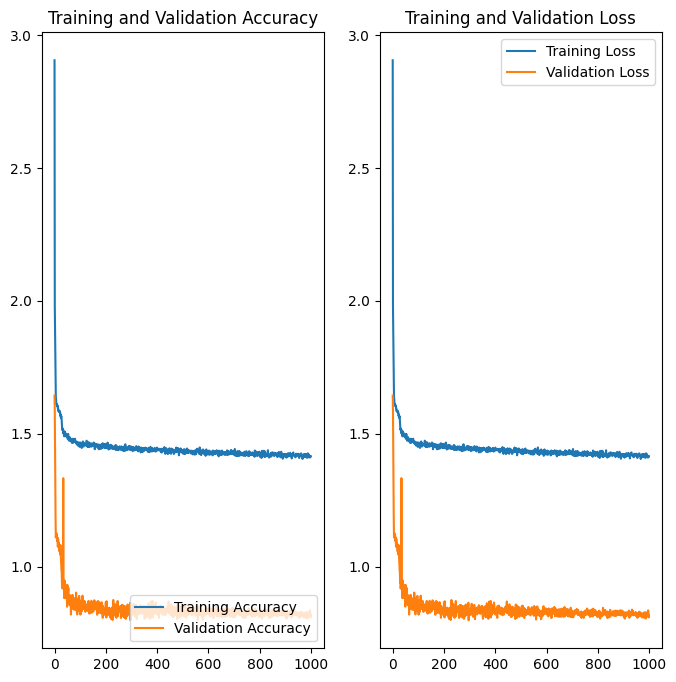

In [70]:
acc = history.history['mae']
val_acc = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Guardamos los datos de Accuracy y Loss

In [71]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 100,200/historycampvec100.csv', index=False)

# Guardamos el modelo

In [72]:
path_to_save = '../../../Modelos/Modelos 100,200'

In [73]:
model.save(path_to_save + '/campovectorial100.h5')

# Importamos el modelo

In [75]:
import keras
import tensorflow as tf
new_model = keras.models.load_model('../../../Modelos/Modelos 100,200/campovectorial100.h5')

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [99]:
import random
from scipy.integrate import solve_ivp

campvec = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    x_range_neg = 0
    x_range_pos = 10
    y_range_neg = 0
    y_range_pos =10

    y1 = np.linspace(x_range_neg, x_range_pos, 100)
    y2 = np.linspace(y_range_neg, y_range_pos, 100)

    Y1, Y2 = np.meshgrid(y1, y2)
    
    t1 = 0

    u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)

    NI, NJ = Y1.shape

    u1, v1 = f(t1, [Y1, Y2])
    u, v = f(t1, [Y1, Y2])
    M = (np.hypot(u, v))
    u /= M
    v /= M

    campvecci = np.append([u1], [v1], axis=0)

    campvec = campvecci
    print('--------------------------------------------')
    print(coef1)

    
campvec = np.array(campvec)

--------------------------------------------
[10, 2, 7, 4, 10, 8, 2]


In [100]:
campvecnone = campvec[None, :]

## Predecimos con los datos nuevos

In [101]:
new_predictions = new_model.predict(campvecnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 18ms/step
[[9. 2. 7. 5. 9. 8. 2.]]


## Encontramos puntos de equilibrio datos reales

In [102]:
from scipy.optimize import fsolve
# Sistema de ecuaciones
def system(Y):
    X, Y = Y
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1
    return [dX_dt, dY_dt]

# Adivinanza inicial para X, Y
initial_guess = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_reales = fsolve(system, initial_guess)
primer_cuadrante_reales = tuple(primer_cuadrante_reales)


print(primer_cuadrante_reales)

(1.2120125893163416, 0.9762566141593871)


## Graficamos con los coeficientes reales

Text(0, 0.5, 'Concentración Y')

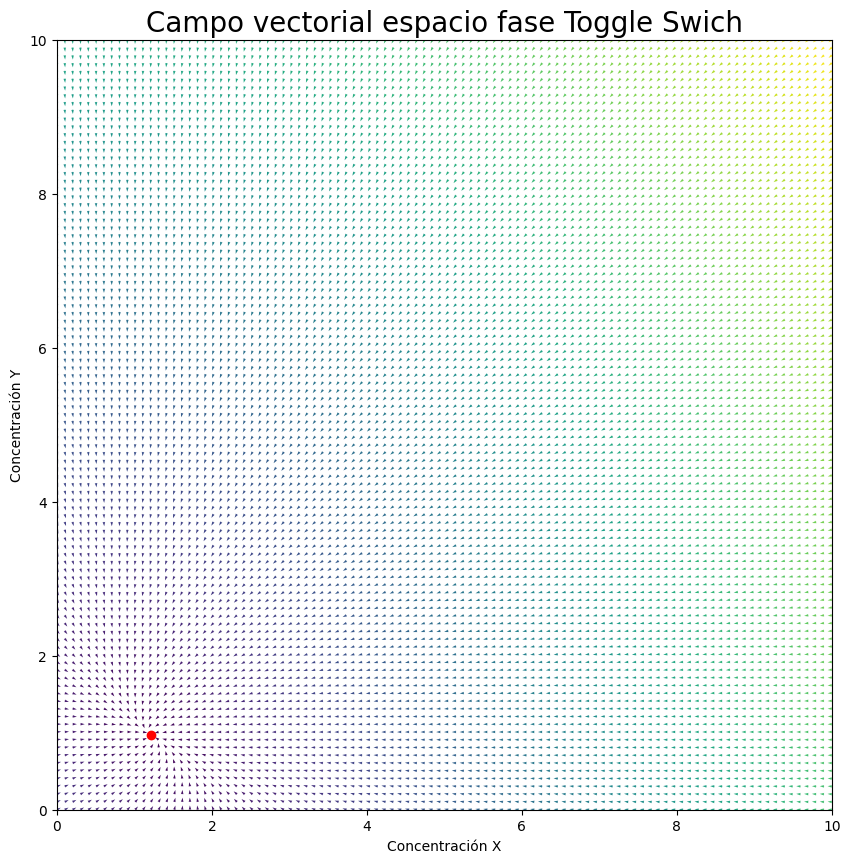

In [103]:
import matplotlib.pyplot as plt

x_values = primer_cuadrante_reales[0]
y_values =primer_cuadrante_reales[1]
y1 = np.linspace(0, 10, 100)
y2 = np.linspace(0, 10, 100)
Y1, Y2 = np.meshgrid(y1, y2)
t1 = 0
u, v = np.zeros(Y1.shape), np.zeros(Y2.shape)
NI, NJ = Y1.shape        
u,v = np.array(campvec)[0,:,:], np.array(campvec)[1,:,:]
M = (np.hypot(u,v))
u /= M
v /= M

plt.figure(figsize=(10,10))
Q = plt.quiver(Y1, Y2, u, v, M, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([0, 10])
plt.ylim([0, 10])
plt.scatter(x_values, y_values, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Encontramos puntos de equilibro datos predecidos

In [104]:
a1pred = new_predictions[0,0]
a2pred = new_predictions[0,1]
b1pred = new_predictions[0,2]
b2pred = new_predictions[0,3]
d1pred = new_predictions[0,4]
d2pred = new_predictions[0,5]
npred = new_predictions[0,6]

def systempred(Ypred):
    Xpred, Ypred = Ypred
    dXpred_dt = a1pred/(1+Ypred**npred)-d1pred*Xpred+b1pred
    dYpred_dt = a2pred/(1+Xpred**npred)-d2pred*Ypred+b1pred
    return [dXpred_dt, dYpred_dt]

# Adivinanza inicial para X, Y
initial_guesspred = [0, 0]

# Encontrar los puntos de equilibrio
primer_cuadrante_predecidos = fsolve(systempred, initial_guesspred)
primer_cuadrante_predecidos = tuple(primer_cuadrante_predecidos)


print(primer_cuadrante_predecidos)

(1.29377682567458, 0.9684978430503335)


## Graficamos con los coeficientes predecidos

Text(0, 0.5, 'Concentración Y')

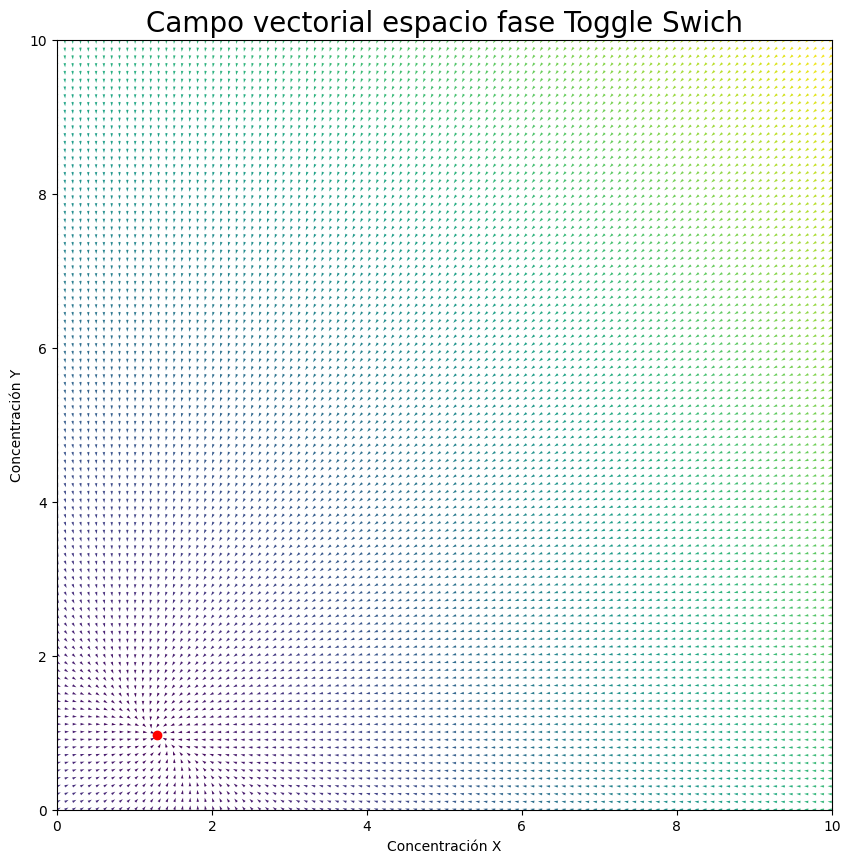

In [105]:
import matplotlib.pyplot as plt

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1pred/(1+Y**npred)-d1pred*X+b1pred
    dY_dt = a2pred/(1+X**npred)-d2pred*Y+b1pred

    return [dX_dt, dY_dt]

x_range_neg = 0
x_range_pos = 10
y_range_neg = 0
y_range_pos = 10

y1pred = np.linspace(x_range_neg, x_range_pos, 100)
y2pred = np.linspace(y_range_neg, y_range_pos, 100)

Y1pred, Y2pred = np.meshgrid(y1pred, y2pred)
    
t1 = 0

upred, vpred = np.zeros(Y1pred.shape), np.zeros(Y2pred.shape)

NI, NJ = Y1.shape

u1pred, v1pred = f(t1, [Y1, Y2])
upred, vpred = f(t1, [Y1, Y2])
Mpred = (np.hypot(upred, vpred))
upred /= Mpred
vpred /= Mpred


x_valuespred = primer_cuadrante_predecidos[0]
y_valuespred =primer_cuadrante_predecidos[1]
plt.figure(figsize=(10, 10))
Q = plt.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy')
plt.title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
plt.xlim([x_range_neg, x_range_pos])
plt.ylim([y_range_neg, y_range_pos])
plt.scatter(x_valuespred, y_valuespred, color='red')  # Puedes cambiar el color como prefieras
plt.xlabel('Concentración X')
plt.ylabel('Concentración Y')

## Graficamos ambos

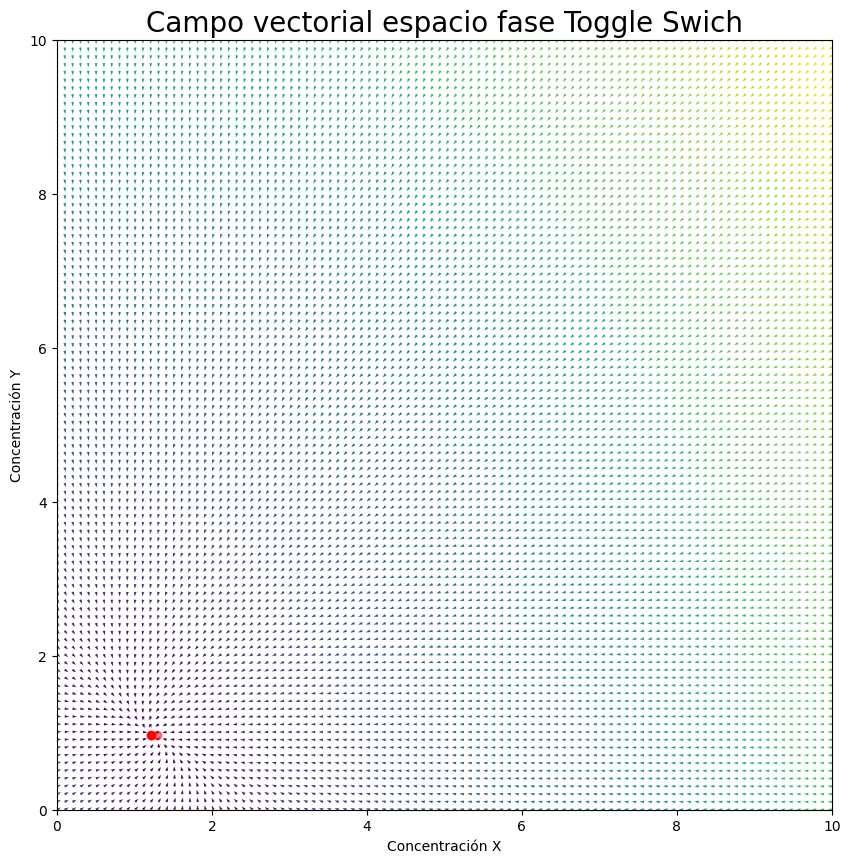

In [106]:
fig, ax = plt.subplots(figsize=(10, 10))

# Primero graficamos la predicción, que debería ser más clara (alpha < 1)
Q = ax.quiver(Y1, Y2, upred, vpred, Mpred, angles='xy', alpha=0.5)

# Luego, graficamos los datos originales, que serán más oscuros (alpha = 1)
Q1 = ax.quiver(Y1, Y2, u, v, M, angles='xy', alpha=1)

ax.scatter(x_valuespred, y_valuespred, color='red', alpha = 0.5)
ax.scatter(x_values, y_values, color='red', alpha = 1)
ax.set_title('Campo vectorial espacio fase Toggle Swich', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

plt.show()

## Graficamos las diferencias

59.95216058922178


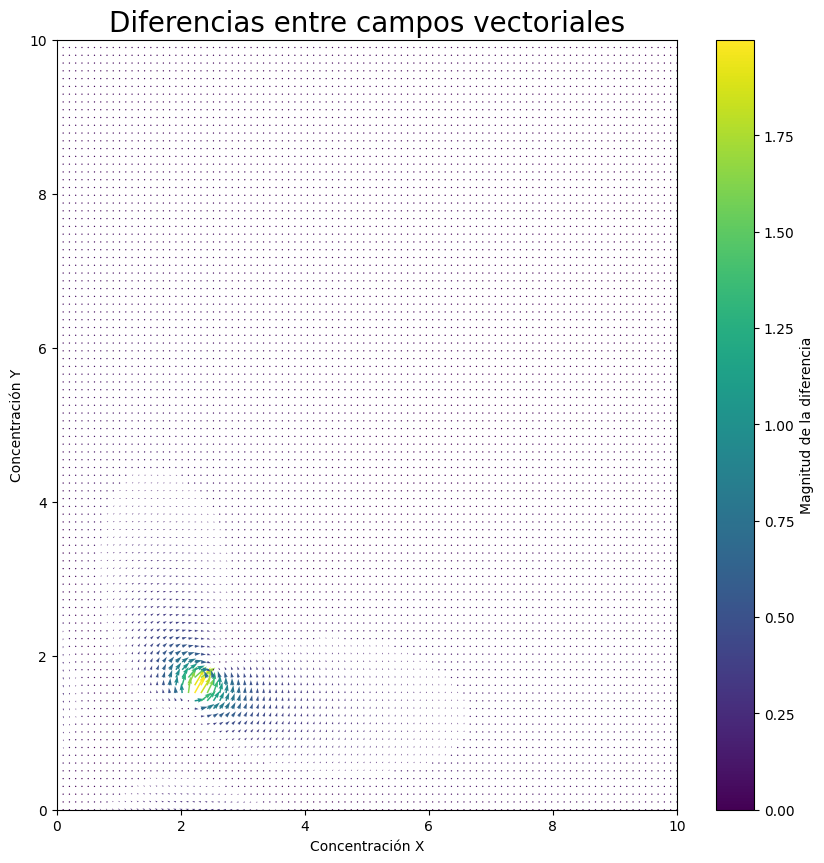

In [85]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Ahora calculamos la magnitud
#M_diff = np.hypot(u_diff2, v_diff2)
M_diff = np.hypot(u_diff, v_diff)

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30
print(rango)
# Escala para las flechas. Aumenta este valor si las flechas son demasiado grandes.

# Graficamos las diferencias
#Q = ax.quiver(Y1, Y2, u_diff2, v_diff2, M_diff, angles='xy')
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy', scale = rango)
#Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff, angles='xy')


ax.set_title('Diferencias entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia')

plt.show()

## Errores relativos 

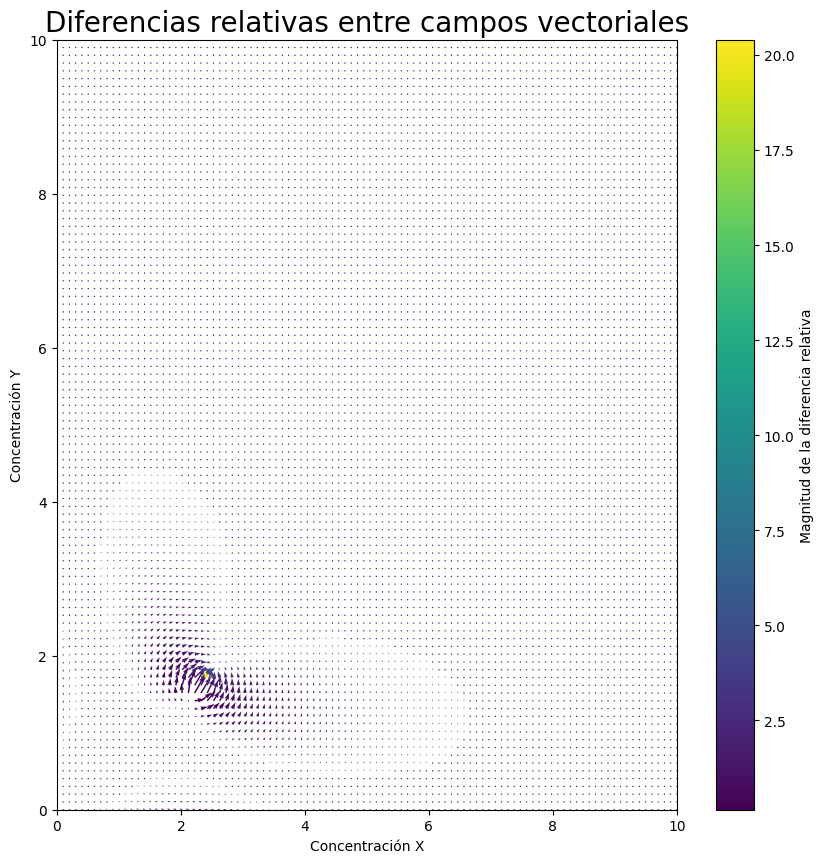

In [86]:
fig, ax = plt.subplots(figsize=(10, 10))

# Calculamos las diferencias
u_diff = u - upred
v_diff = v - vpred

# Aseguramos que ningún vector tenga una magnitud exactamente igual a cero
epsilon = 1e-7

# Calculamos la magnitud del vector original y de la diferencia
M_orig = np.hypot(u1, v1) + epsilon
M_diff = np.hypot(u1pred, v1pred)

# Calculamos la diferencia relativa
M_diff_rel = M_diff / M_orig

#Calcula la magnitud de los vectores
magnitudes = np.sqrt(u_diff**2 + v_diff**2)

# Calcula el rango de las magnitudes
rango = (np.max(magnitudes) - np.min(magnitudes))*30

# Graficamos las diferencias relativas
Q = ax.quiver(Y1, Y2, u_diff, v_diff, M_diff_rel, angles='xy', scale = rango)

ax.set_title('Diferencias relativas entre campos vectoriales', fontsize=20)
ax.set_xlim([0, 10])
ax.set_ylim([0, 10])
ax.set_xlabel('Concentración X')
ax.set_ylabel('Concentración Y')

# Creamos una leyenda para la magnitud de las flechas
cbar = plt.colorbar(Q, ax=ax)
cbar.set_label('Magnitud de la diferencia relativa')

plt.show()

In [87]:
max_index_flattened = M_diff_rel.argmax()
max_coords = np.unravel_index(max_index_flattened, M_diff_rel.shape)
M_orig[max_coords]
print('El valor máximo de error relativo es de:', M_diff_rel.max() )
print('El valor de u1 en el error relativo máximo es:',u1[max_coords])
print('El valor de u1pred en el error relativo máximo es:',u1pred[max_coords])
print('El valor de v1 en el error relativo máximo es:',v1[max_coords])
print('El valor de v1pred en el error relativo máximo es:',v1pred[max_coords])

El valor máximo de error relativo es de: 20.41167984006856
El valor de u1 en el error relativo máximo es: -0.1212121212121211
El valor de u1pred en el error relativo máximo es: -1.5450039427734588
El valor de v1 en el error relativo máximo es: -0.020202020202020776
El valor de v1pred en el error relativo máximo es: -1.975954232591402
